<a href="https://colab.research.google.com/github/marcellobenigno/GST102FOSS4GLabs/blob/master/operacoes_que_geram_novas_geometrias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Operações que geram novas geometrias:

## Monte o Google Drive:

In [2]:
# Monte o Google Drive
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# instale a biblioteca fiona, necessária para ler os dados de um GeoPackage
!pip install fiona -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 32.1 MB/s eta 0:00:00


In [7]:
# importe a biblioteca Fiona e o GeoPandas
import fiona
import geopandas as gpd

In [8]:
# localize no seu drive, a pasta onde foi salvo o GeoPackage e aponte o path do mesmo na variável abaixo:
gpkg = '/content/drive/MyDrive/dados_espaciais/pb.gpkg'

In [9]:
# Listando as camadas no GeoPackage
for lyr in fiona.listlayers(gpkg):
    print(lyr)

drenagem
sedes
estados_ne
limite_pb
municipios
pocos
densidade_pb
malha_viaria
poi
layer_styles


## Buffer:

### Cria uma área de influência em torno de um objeto geográfico, a partir de um valor de raio.

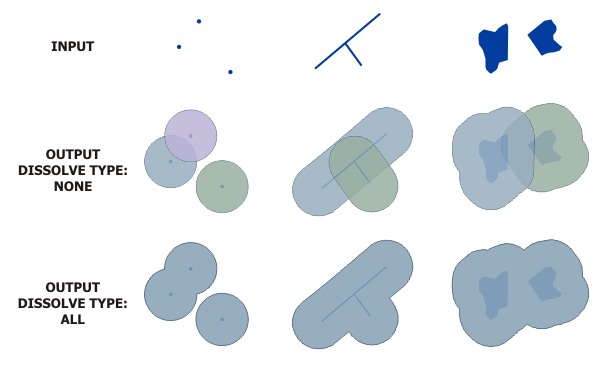

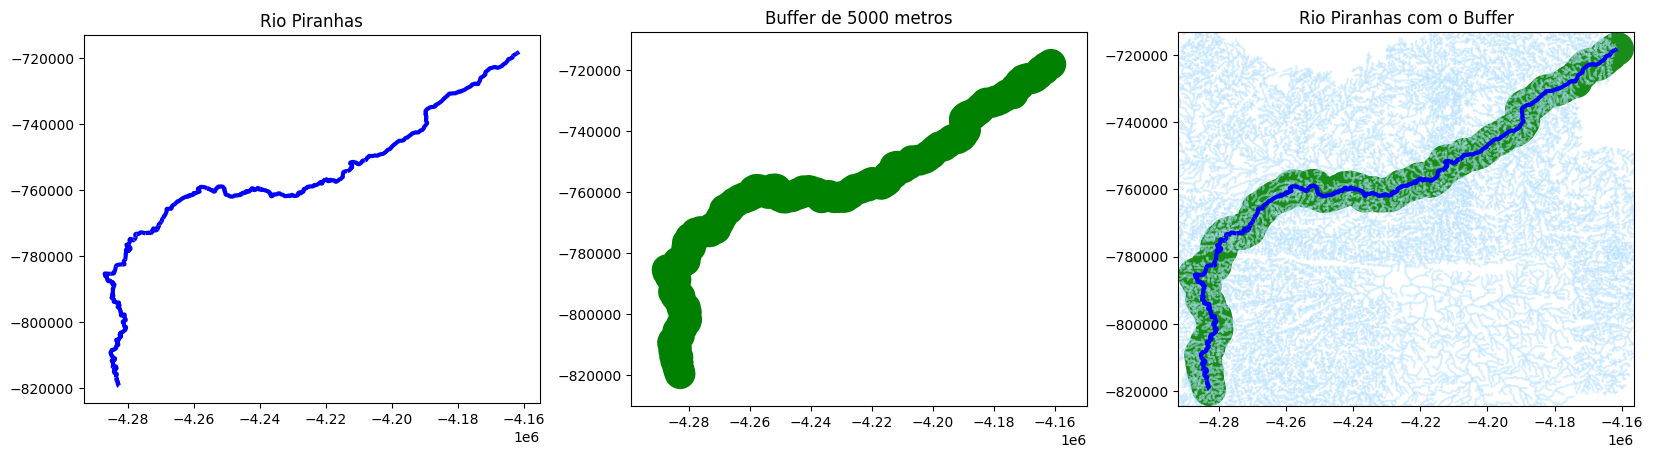

In [53]:
# Carregar a camada de drenagem
drenagem = gpd.read_file(gpkg, layer='drenagem')

# Filtrar pelo nome 'Rio Piranhas'
query = drenagem['nome'] == 'Rio Piranhas'
rio_piranhas = drenagem.loc[query]

# Alterar o sistema de coordenadas
rio_piranhas = rio_piranhas.to_crs(epsg=3857)

# Criar o buffer de 5000 metros
r = 5000

buffered = rio_piranhas.geometry.buffer(r)

# Combinar todas as geometrias em uma só usando unary_union
combined_geometry = buffered.union_all()

# Criar um GeoDataFrame com a geometria combinada
buffer_5km = gpd.GeoDataFrame({'nome_rio':'Rio Piranhas', 'raio_buffer_m': r, 'geometry': [combined_geometry]}, crs=rio_piranhas.crs)

# Verificar o resultado
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,6))

rio_piranhas.plot(ax=ax1, color='blue', linewidth=3)
buffer_5km.plot(ax=ax2, color='green', linewidth=3)


drenagem.to_crs(epsg=3857).plot(ax=ax3, color='#b3e0ff', alpha=0.5)
buffer_5km.plot(ax=ax3, color='green', linewidth=3,  alpha=0.9)
rio_piranhas.plot(ax=ax3, color='blue', linewidth=3)

# Aplicar zoom na extensão do buffer
xmin, ymin, xmax, ymax = buffer_5km.total_bounds
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)

ax1.set_title('Rio Piranhas')
ax2.set_title(f'Buffer de {r} metros')
ax3.set_title('Rio Piranhas com o Buffer')

plt.show()

## Dissolve
###Permite agrupar feições (como polígonos ou linhas) com base em um atributo comum, eliminando os limites internos entre elas.

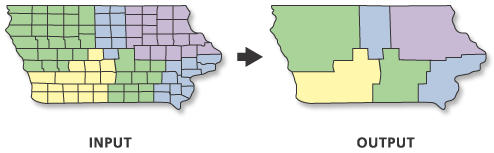

### Exemplo: Dissolva os municípioss em função das mesorregiões:

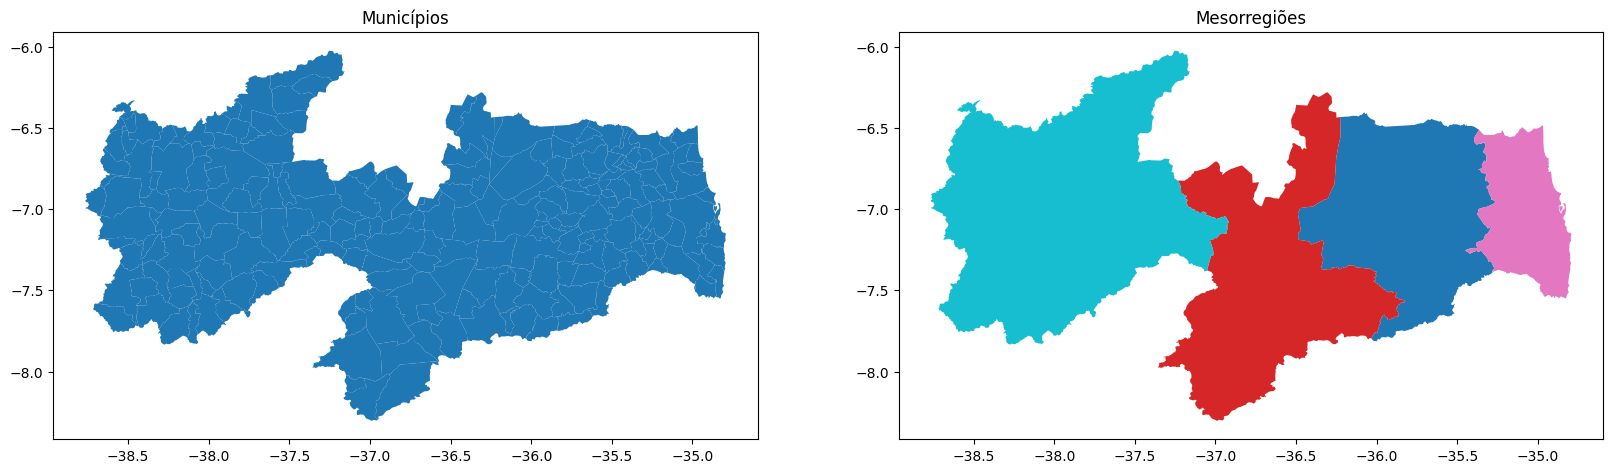

In [48]:
# Carregar o layer dos municípios
municipios = gpd.read_file(gpkg, layer="municipios")

# Dissolver os municípios com base nas mesorregiões
mesorregioes = municipios.dissolve(by='mesoregiao')

# Resetar o índice para que 'mesoregiao' volte a ser uma coluna
mesorregioes = mesorregioes.reset_index()

# Exibir o resultado (agora a coluna 'mesoregiao' está disponível)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))

municipios.plot(ax=ax1)
mesorregioes.plot(ax=ax2, column='mesoregiao')

ax1.set_title('Municípios')
ax2.set_title('Mesorregiões')

plt.show()

## Intersection:

### Extrai as áreas de sobreposição entre duas ou mais camadas de dados.

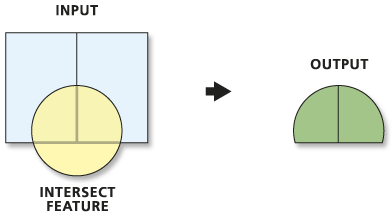

### Exemplo: Gere a interseção do Buffer do Rio Piranhas com os municípios

In [ ]:
print('CRS do Buffer: ', buffer_5km.crs)

print('CRS dos Municípios: ', municipios.crs)

# alterar o CRS para o mesmo do GDF dos Municípios:
buffer_5km = buffer_5km.to_crs(4326)

intersecao = gpd.overlay(municipios, buffer_5km, how='intersection')

intersecao.head()

CRS do Buffer:  EPSG:3857
CRS dos Municípios:  EPSG:4326


,nome,cod_ibge_m,slug,microregiao,mesoregiao,populacao_rural,populacao_urbana,populacao_total,sede,nome_rio,raio_buffer_m,geometry
0,Marizópolis,2509156,marizopolis,Sousa,Sertão Paraibano,746,4823,5569,A,Rio Piranhas,5000,"POLYGON ((-38.34873 -6.88093, -38.34884 -6.881..."
1,Nazarezinho,2510006,nazarezinho,Sousa,Sertão Paraibano,4545,2727,7272,A,Rio Piranhas,5000,"POLYGON ((-38.39843 -6.97801, -38.4004 -6.9732..."
2,São Bento,2513901,sao-bento,Catolé do Rocha,Sertão Paraibano,6318,21513,27831,A,Rio Piranhas,5000,"POLYGON ((-37.3936 -6.397, -37.39612 -6.40114,..."
3,Riacho dos Cavalos,2512804,riacho-dos-cavalos,Catolé do Rocha,Sertão Paraibano,4985,2696,7681,A,Rio Piranhas,5000,"POLYGON ((-37.5396 -6.49408, -37.53608 -6.4978..."
4,São João do Rio do Peixe,2500700,sao-joao-do-rio-do-peixe,Cajazeiras,Sertão Paraibano,11726,6122,17848,A,Rio Piranhas,5000,"POLYGON ((-38.36345 -6.82457, -38.36397 -6.845..."


In [ ]:
intersecao = intersecao.rename(columns={'nome': 'municipio'})

intersecao.head()

,municipio,cod_ibge_m,slug,microregiao,mesoregiao,populacao_rural,populacao_urbana,populacao_total,sede,nome_rio,raio_buffer_m,geometry
0,Marizópolis,2509156,marizopolis,Sousa,Sertão Paraibano,746,4823,5569,A,Rio Piranhas,5000,"POLYGON ((-38.34873 -6.88093, -38.34884 -6.881..."
1,Nazarezinho,2510006,nazarezinho,Sousa,Sertão Paraibano,4545,2727,7272,A,Rio Piranhas,5000,"POLYGON ((-38.39843 -6.97801, -38.4004 -6.9732..."
2,São Bento,2513901,sao-bento,Catolé do Rocha,Sertão Paraibano,6318,21513,27831,A,Rio Piranhas,5000,"POLYGON ((-37.3936 -6.397, -37.39612 -6.40114,..."
3,Riacho dos Cavalos,2512804,riacho-dos-cavalos,Catolé do Rocha,Sertão Paraibano,4985,2696,7681,A,Rio Piranhas,5000,"POLYGON ((-37.5396 -6.49408, -37.53608 -6.4978..."
4,São João do Rio do Peixe,2500700,sao-joao-do-rio-do-peixe,Cajazeiras,Sertão Paraibano,11726,6122,17848,A,Rio Piranhas,5000,"POLYGON ((-38.36345 -6.82457, -38.36397 -6.845..."


<Axes: >

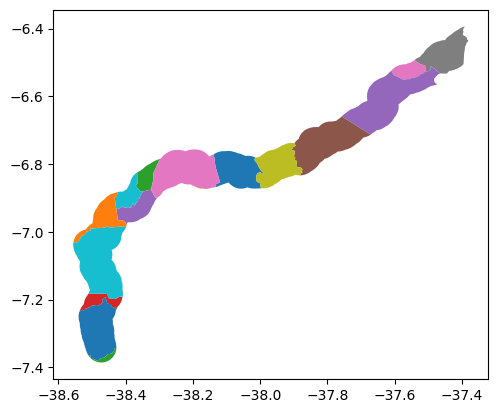

In [ ]:
intersecao.plot(column='municipio')

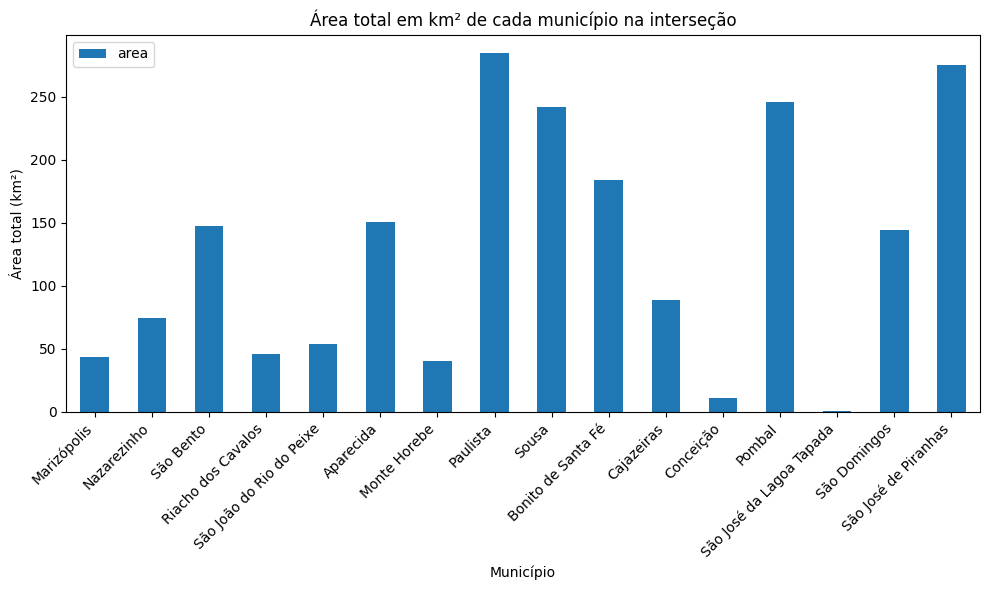

In [ ]:

import matplotlib.pyplot as plt

intersecao.to_crs(3857, inplace=True)

intersecao['area'] = intersecao.geometry.area / 1000000

intersecao.plot.bar(x='municipio', y='area', figsize=(10, 6))
plt.xlabel("Município")
plt.ylabel("Área total (km²)")
plt.title("Área total em km² de cada município na interseção")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Symmetric Difference

### Operação que resulta nos elementos que estão em um ou outro conjunto, mas não na **interseção** entre eles. No contexto de geometria e análise espacial, isso significa que a Diferença Simétrica de dois polígonos ou áreas é a região que pertence a apenas **um** deles, **excluindo** a área em comum (a interseção)

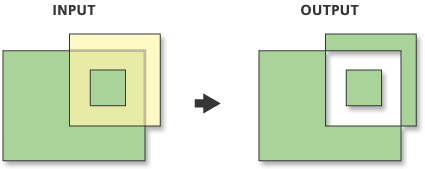

### Exemplo: Para os poços que estão no município de João Pessoa, realize a seguinte análise:

 - Crie um buffer de 2km para esses poços
 - Extraia a área que não possui os poços através da diferença simétrica  

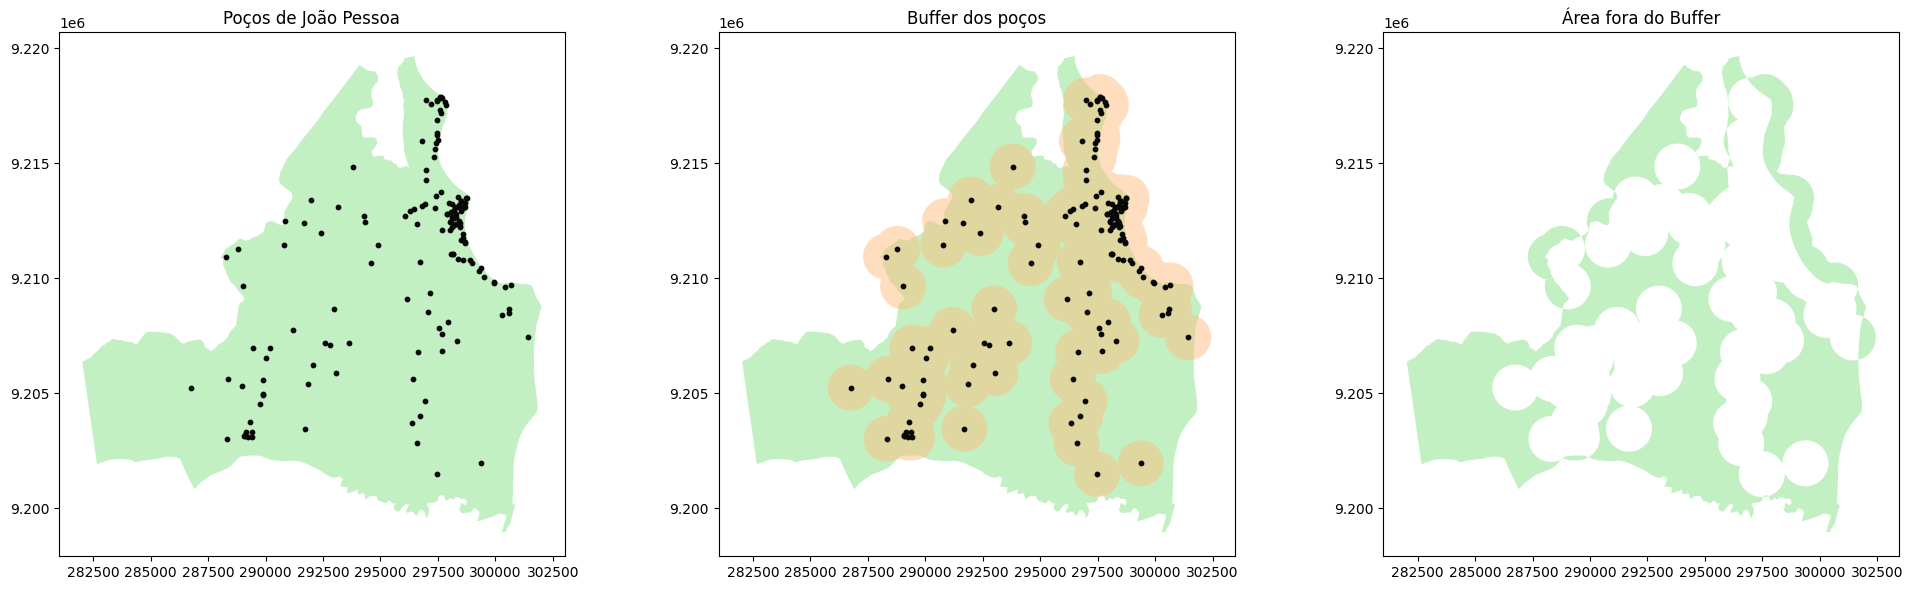

In [46]:
# Carregar dados
pocos = gpd.read_file(gpkg, layer='pocos')
municipios = gpd.read_file(gpkg, layer="municipios")

# Filtrar João Pessoa
query = municipios['nome'] == 'João Pessoa'
jp = municipios.loc[query]

# Filtrar poços dentro de João Pessoa
query = pocos.within(jp.geometry.item())
pocos_jp = pocos.loc[query]

# Transformar o CRS para UTM 25S
jp_utm = jp.to_crs(31985)
pocos_utm = pocos_jp.to_crs(31985)

# Criar o buffer de 2km (1000 metros) para os poços
pocos_geom_union = pocos_utm.buffer(1000).union_all()  # Isso cria um MultiPolygon

# Transformar o buffer em GeoDataFrame
pocos_buffer_gdf = gpd.GeoDataFrame(geometry=[pocos_geom_union], crs=jp_utm.crs)

# Realizar a diferença simétrica
jp_diff = gpd.overlay(jp_utm, pocos_buffer_gdf, how='symmetric_difference')

# Visualizar o resultado
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,6))
jp_utm.plot(ax=ax1, color='#c2f0c2')
pocos_utm.plot(ax=ax1, color='#080808', markersize=10)

jp_utm.plot(ax=ax2, color='#c2f0c2')
pocos_buffer_gdf.plot(ax=ax2, color='#ffbf80', alpha=0.5)
pocos_utm.plot(ax=ax2, color='#080808', markersize=10)

jp_diff.plot(ax=ax3, color='#c2f0c2')

ax1.set_title('Poços de João Pessoa')
ax2.set_title('Buffer dos poços')
ax3.set_title('Área fora do Buffer')

plt.tight_layout()

plt.show()

<Axes: >

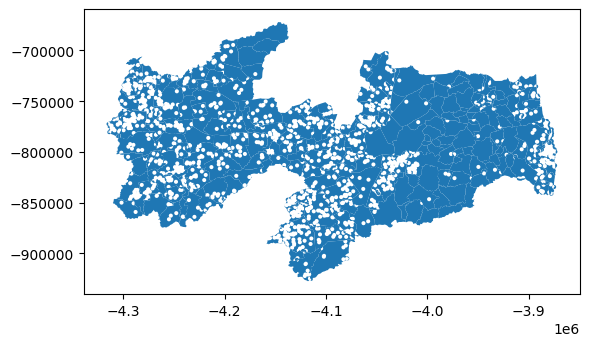

In [ ]:
import pandas as pd
import geopandas as gpd

# Carregar dados
pocos = gpd.read_file(gpkg, layer='pocos')
municipios = gpd.read_file(gpkg, layer="municipios")

# Transformar os dados para o CRS EPSG 3857 (Web Mercator)
pocos = pocos.to_crs(epsg=3857)
municipios = municipios.to_crs(epsg=3857)

# Realizar o processo para todos os municípios
results = []

for _, municipio in municipios.iterrows():
    # Filtrar poços dentro do município
    query = pocos.within(municipio.geometry)
    pocos_municipio = pocos.loc[query]

    # Criar o buffer de 2km (2000 metros) para os poços
    pocos_geom_union = pocos_municipio.buffer(2000).union_all()  # Isso cria um MultiPolygon

    # Transformar o buffer em GeoDataFrame
    pocos_buffer_gdf = gpd.GeoDataFrame(geometry=[pocos_geom_union], crs=pocos.crs)

    # Transformar a geometria do município em GeoDataFrame
    municipio_gdf = gpd.GeoDataFrame(geometry=[municipio.geometry], crs=municipios.crs)

    # Realizar a diferença simétrica
    municipio_diff = gpd.overlay(municipio_gdf, pocos_buffer_gdf, how='symmetric_difference')

    # Adicionar o resultado à lista
    results.append(municipio_diff)

# Combinar todos os resultados em um único GeoDataFrame
final_result = gpd.GeoDataFrame(pd.concat(results, ignore_index=True), crs=municipios.crs)

# Visualizar o resultado final
final_result.plot()


<Axes: >

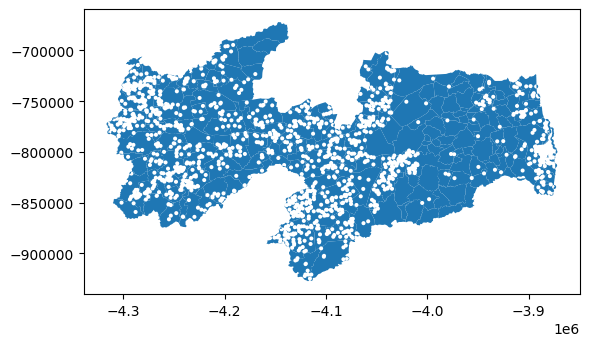

In [ ]:
import geopandas as gpd
import pandas as pd

# Carregar dados
pocos = gpd.read_file(gpkg, layer='pocos')
municipios = gpd.read_file(gpkg, layer="municipios")

# Transformar os dados para o CRS EPSG 3857 (Web Mercator)
pocos = pocos.to_crs(epsg=3857)
municipios = municipios.to_crs(epsg=3857)

# Criar um buffer de 2km (2000 metros) para todos os poços
pocos_geom_union = pocos.buffer(2000).union_all()  # Cria um MultiPolygon

# Transformar o buffer em um GeoDataFrame
pocos_buffer_gdf = gpd.GeoDataFrame(geometry=[pocos_geom_union], crs=pocos.crs)

# Realizar a diferença simétrica para todos os municípios
# Realizando o overlay sem for loop
municipios_diff = gpd.overlay(municipios, pocos_buffer_gdf, how='symmetric_difference', keep_geom_type=False)

# Visualizar o resultado final
municipios_diff.plot()